In [1]:
from pymongo import MongoClient
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *

In [2]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7f1bb40907d0>,
 <pyspark.context.SparkContext at 0x7f1bc29f38d0>)

### load utility matrix

In [9]:
# load data frame from csv
data_df = pd.read_csv("model_df.csv", sep='\t')

# drop duplicates
data_df = data_df.drop_duplicates(subset=['route_id', 'user_id'])

y_data = data_df[['route_id', 'user_id','rating']]
x_data = data_df.drop(['rating', 'route_id', 'user_id', 'member_since', 'Unnamed: 0'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=42)

In [43]:
y_train[y_train['user_id'] == 560]

,route_id,user_id,rating
2825,370,560,4
5765,684,560,3
11226,1199,560,4
21128,2236,560,3
16397,1704,560,3
29000,3473,560,3
19840,2085,560,3
13621,1394,560,3
24016,2662,560,3
11924,1243,560,4


In [10]:
# Convert to a Spark DataFrame
y_train_spark = spark.createDataFrame(y_train)
y_test_spark = spark.createDataFrame(y_test)

In [11]:
y_train_spark.show()

+--------+-------+------+
|route_id|user_id|rating|
+--------+-------+------+
|     370|    932|     3|
|     987|   1289|     2|
|    1518|    973|     3|
|    2013|   1669|     3|
|    1454|   1923|     4|
|     684|   1094|     2|
|    3608|    399|     2|
|    1496|   1647|     3|
|     981|    658|     3|
|    2090|   1660|     3|
|    3059|   1849|     3|
|    3244|   1017|     3|
|     798|   1148|     2|
|    1511|    917|     3|
|    1518|    641|     3|
|      26|   1134|     3|
|    1279|    472|     2|
|    2013|    614|     2|
|    1687|    218|     2|
|    1199|    925|     4|
+--------+-------+------+
only showing top 20 rows



In [6]:
path = '/home/david/work/project/Rock-Climbing-Route-Recommender/src/alsmodel2'

### save model

In [12]:
als_model = ALS(userCol='route_id',
                itemCol='user_id',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )
recommender = als_model.fit(y_train_spark)

In [9]:
recommender.save(path)

### load als model

In [7]:
recommender = ALSModel.load(path)

In [37]:
# Make predictions for the whole test set
predictions = recommender.transform(y_test_spark)

In [38]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()

### grab gradient boosting pickle model

In [15]:
from sklearn.externals import joblib
gb = joblib.load('../pickle/gb_model.pkl') 
gb_predict = gb.predict(X_test)

In [16]:
feat_imp = gb.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb.feature_importances_},
                           index=X_test.columns)

In [17]:
feat_scores_lim = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False).head(10)

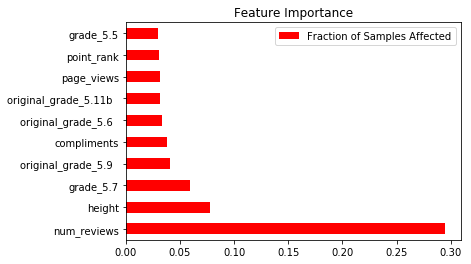

In [57]:
feat_scores_lim.plot(kind='barh', color='red', title= 'Feature Importance')
plt.savefig('../data/images/gb_features.jpg')

### fill nulls with gb model prediction

In [11]:
null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]

In [26]:
predictions_df.ix[null_ind, 'prediction'] = gb_predict[null_ind]

In [27]:
predictions_df.head(18)

,rating,route_id,user_id,prediction
0,3,1614,213,2.328690
1,3,1530,1329,2.045483
2,2,2606,1038,1.797803
3,1,1986,2006,0.876302
4,3,2001,604,2.306329
5,4,1319,1742,2.749723
6,3,1865,404,2.691462
7,4,3059,472,3.665307
8,3,1199,1943,3.082814
9,2,287,248,2.379909


In [42]:
predictions_df[predictions_df['user_id'] == 560]

,route_id,user_id,rating,prediction
2343,3127,560,3,3.001509
2344,955,560,4,3.543416
2345,3350,560,2,2.690138
2346,199,560,3,2.512575
2347,2416,560,4,3.634678


In [41]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

In [19]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [20]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.72874976034046512

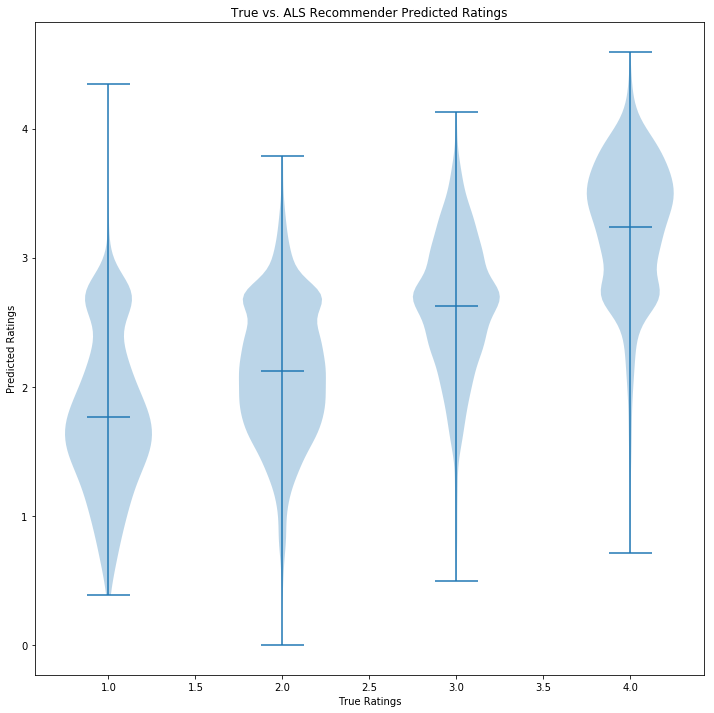

In [59]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [60]:
fig.savefig('../data/images/violin_updated.jpg')

### try weighted

In [17]:
predictions_df['weighted'] = (0.8 * predictions_df['prediction']) + (0.2 * pd.DataFrame(gb_predict)[0])

In [18]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2

In [19]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.69795460784827068

### reweight based on num of reviews

In [20]:
normalized_rating_count = X_test['num_reviews'] / float(X_test['num_reviews'].max())

for j in np.linspace(0.4, 0.6, num=100):
    predictions_df['weighted2'] = predictions_df['weighted'] + (j * normalized_rating_count).tolist()
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
    # Calculate RMSE
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    print "rmse: {}, weight: {}".format(rmse, j)

rmse: 0.689407293508, weight: 0.4
rmse: 0.689392573554, weight: 0.40202020202
rmse: 0.689378141901, weight: 0.40404040404
rmse: 0.689363998568, weight: 0.406060606061
rmse: 0.689350143573, weight: 0.408080808081
rmse: 0.689336576932, weight: 0.410101010101
rmse: 0.689323298663, weight: 0.412121212121
rmse: 0.689310308783, weight: 0.414141414141
rmse: 0.689297607307, weight: 0.416161616162
rmse: 0.689285194252, weight: 0.418181818182
rmse: 0.689273069633, weight: 0.420202020202
rmse: 0.689261233466, weight: 0.422222222222
rmse: 0.689249685766, weight: 0.424242424242
rmse: 0.689238426546, weight: 0.426262626263
rmse: 0.689227455821, weight: 0.428282828283
rmse: 0.689216773605, weight: 0.430303030303
rmse: 0.689206379911, weight: 0.432323232323
rmse: 0.689196274753, weight: 0.434343434343
rmse: 0.689186458142, weight: 0.436363636364
rmse: 0.689176930092, weight: 0.438383838384
rmse: 0.689167690614, weight: 0.440404040404
rmse: 0.68915873972, weight: 0.442424242424
rmse: 0.689150077422, we

In [21]:
weight1 = 0.505050505051
predictions_df['weighted2'] = predictions_df['weighted'] + (weight1 * normalized_rating_count).tolist()
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
print "RMSE:", np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

RMSE: 0.689024446135


### find user predictions

In [21]:
data = pd.DataFrame(columns=['route_id', 'user_id'])
data['user_id'] = (0 * y_data['route_id']) + 560 
data['route_id'] = y_data['route_id']
one_row_spark_df = spark.createDataFrame(data)
# Get the recommender's prediction
recs = recommender.transform(one_row_spark_df)
recs.show()

+--------+-------+----------+
|route_id|user_id|prediction|
+--------+-------+----------+
|     148|    560| 0.7688358|
|     463|    560| 0.9369185|
|     463|    560| 0.9369185|
|     463|    560| 0.9369185|
|     463|    560| 0.9369185|
|     463|    560| 0.9369185|
|     463|    560| 0.9369185|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
|     471|    560| 0.9086337|
+--------+-------+----------+
only showing top 20 rows



In [22]:
recs_df = recs.toPandas().drop_duplicates(subset='route_id')
recs_df.sort_values('prediction', ascending=False).head(6)

,route_id,user_id,prediction
4911,1978,560,4.296441
26332,2538,560,4.296441
22557,595,560,4.296441
9066,1021,560,4.296441
10792,3369,560,4.296441
14885,1384,560,4.146386


In [ ]:
df = data_df.drop_duplicates(subset=['route_id'])

In [34]:
df = df.reset_index().drop('index', axis=1)

In [35]:
df['route_id'].tolist() == recs_df['route_id'].tolist()

True

In [37]:
recs_df = recs_df.reset_index().drop('index', axis=1)

In [38]:
normalized_rating_count = df['num_reviews'] / float(df['num_reviews'].max())

In [39]:
recs_df['new_pred'] = recs_df['prediction'] + (normalized_rating_count * 0.5)

In [40]:
recs_df.sort_values('new_pred', ascending=False).head(6)

,route_id,user_id,prediction,new_pred
3332,3369,560,4.296441,4.298075
1978,1978,560,4.296441,4.298075
595,595,560,4.296441,4.298075
1021,1021,560,4.296441,4.298075
2521,2538,560,4.296441,4.298075
1199,1199,560,3.658501,4.158501


In [29]:
recs_df.sort_values('prediction', ascending=False).head(6)

,route_id,user_id,prediction
4911,1978,560,4.296441
26332,2538,560,4.296441
22557,595,560,4.296441
9066,1021,560,4.296441
10792,3369,560,4.296441
14885,1384,560,4.146386
